# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [59]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

from sklearn.manifold import TSNE

In [3]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [4]:
edges = [tuple(x) for x in data.values.tolist()]

In [5]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [6]:
# A = list(nx.connected_component_subgraphs(B))[0]
A = [B.subgraph(element) for element in nx.connected_components(B)][0]

In [7]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


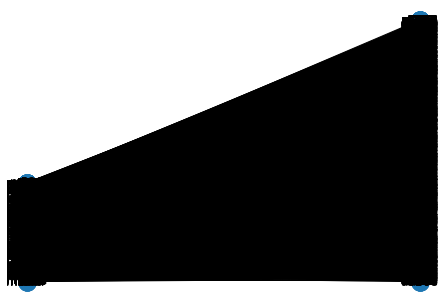

In [8]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [9]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [10]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [11]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [12]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [13]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

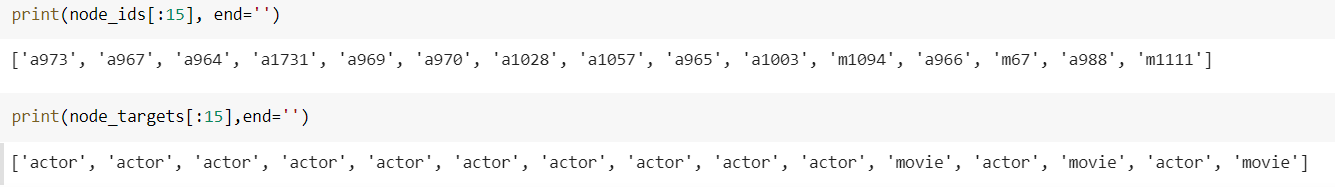

In [22]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
     
    for x,y,z in zip(node_ids, node_targets, node_embeddings):
        if y == 'actor':
            actor_nodes.append(x)
            actor_embeddings.append(z)
        else:
            movie_nodes.append(x)
            movie_embeddings.append(z)
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [23]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [24]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [25]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [36]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    max_graph_len = len(max(nx.connected_component_subgraphs(graph), key=len))
    cost1= (1/number_of_clusters) * max_graph_len / len(graph)
    
    return cost1

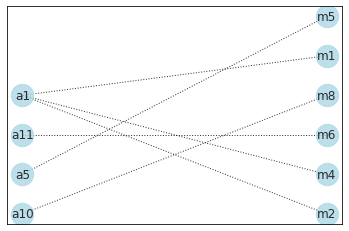

In [38]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [39]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [52]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    actor_degree = 0
    distinct_movies = 0
    for key, val in graded_graph.degree:

        if key[0] == 'a':
            actor_degree += val
        else:
            distinct_movies += 1
    cost2= (1/number_of_clusters) * (actor_degree/distinct_movies)
    
    return cost2

<font color='cyan'>Grader function - 4</font>

In [53]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

In [84]:
clusters = list(range(2,101))
final_metrics = []
for k in clusters:
    number_of_clusters = k
    print('Clustering data into {} clusters'.format(k))
    kms = KMeans(n_clusters=number_of_clusters, random_state=42)
    kms.fit(actor_embeddings)
    pred = kms.predict(actor_embeddings)
    # https://stackoverflow.com/questions/60935289/ego-graph-in-networkx
    cost1_metric = 0
    cost2_metric = 0
    for ele in np.random.choice(actor_nodes, number_of_cluster):
            temp_sub_graph = A.subgraph(ele)
            cost1_metric += cost1(temp_sub_graph, number_of_clusters)
            cost2_metric += cost2(temp_sub_graph, number_of_clusters)
    final_cost = cost1_metric * cost2_metric
    final_metrics.append(final_cost)
    print('Cost1 Metric Value',cost1_metric)
    print('Cost2 Metric Value',cost2_metric)
    print('Final Metric Value',final_cost)

Clustering data into 1 clusters
Cost1 Metric Value 4.0
Cost2 Metric Value 4.0
Final Metric Value 16.0
Clustering data into 2 clusters
Cost1 Metric Value 2.0
Cost2 Metric Value 2.0
Final Metric Value 4.0
Clustering data into 3 clusters
Cost1 Metric Value 1.3333333333333333
Cost2 Metric Value 1.3333333333333333
Final Metric Value 1.7777777777777777
Clustering data into 4 clusters
Cost1 Metric Value 1.0
Cost2 Metric Value 1.0
Final Metric Value 1.0
Clustering data into 5 clusters
Cost1 Metric Value 0.8
Cost2 Metric Value 0.8
Final Metric Value 0.6400000000000001
Clustering data into 6 clusters
Cost1 Metric Value 0.6666666666666666
Cost2 Metric Value 0.6666666666666666
Final Metric Value 0.4444444444444444
Clustering data into 7 clusters
Cost1 Metric Value 0.5714285714285714
Cost2 Metric Value 0.5714285714285714
Final Metric Value 0.32653061224489793
Clustering data into 8 clusters
Cost1 Metric Value 0.5
Cost2 Metric Value 0.5
Final Metric Value 0.25
Clustering data into 9 clusters
Cost1 M

Cost1 Metric Value 0.06779661016949153
Cost2 Metric Value 0.06779661016949153
Final Metric Value 0.004596380350474002
Clustering data into 60 clusters
Cost1 Metric Value 0.06666666666666667
Cost2 Metric Value 0.06666666666666667
Final Metric Value 0.0044444444444444444
Clustering data into 61 clusters
Cost1 Metric Value 0.06557377049180328
Cost2 Metric Value 0.06557377049180328
Final Metric Value 0.004299919376511691
Clustering data into 62 clusters
Cost1 Metric Value 0.06451612903225806
Cost2 Metric Value 0.06451612903225806
Final Metric Value 0.004162330905306971
Clustering data into 63 clusters
Cost1 Metric Value 0.06349206349206349
Cost2 Metric Value 0.06349206349206349
Final Metric Value 0.004031242126480221
Clustering data into 64 clusters
Cost1 Metric Value 0.0625
Cost2 Metric Value 0.0625
Final Metric Value 0.00390625
Clustering data into 65 clusters
Cost1 Metric Value 0.06153846153846154
Cost2 Metric Value 0.06153846153846154
Final Metric Value 0.0037869822485207105
Clustering

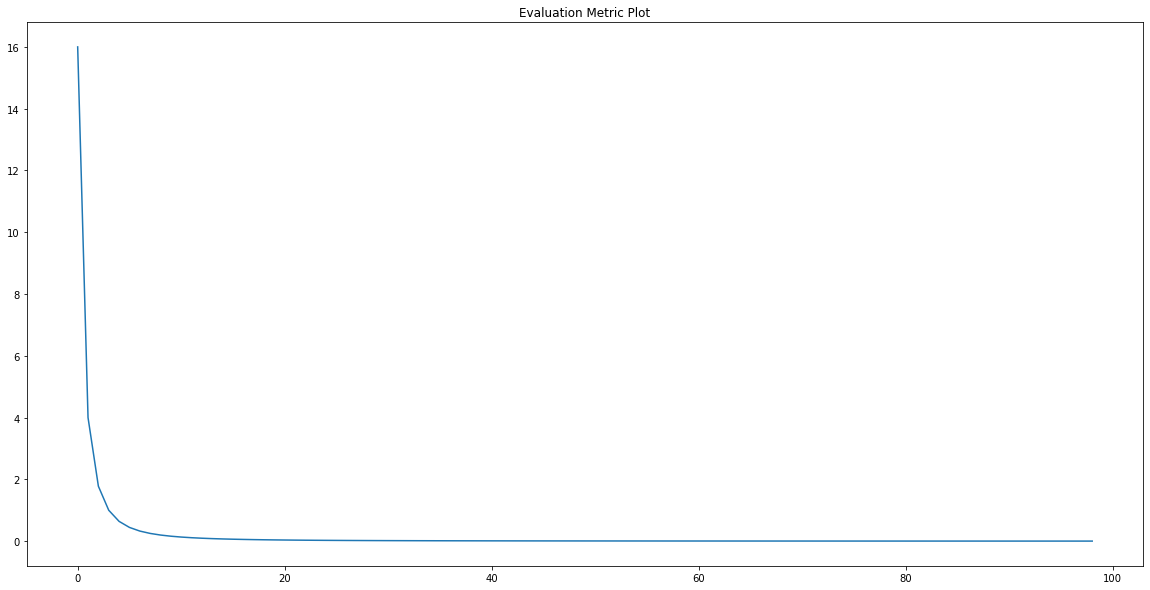

In [97]:
_, ax = plt.subplots(1,1, figsize=(20, 10))
ax.plot(final_metrics)
ax.set_title('Evaluation Metric Plot')
plt.show()

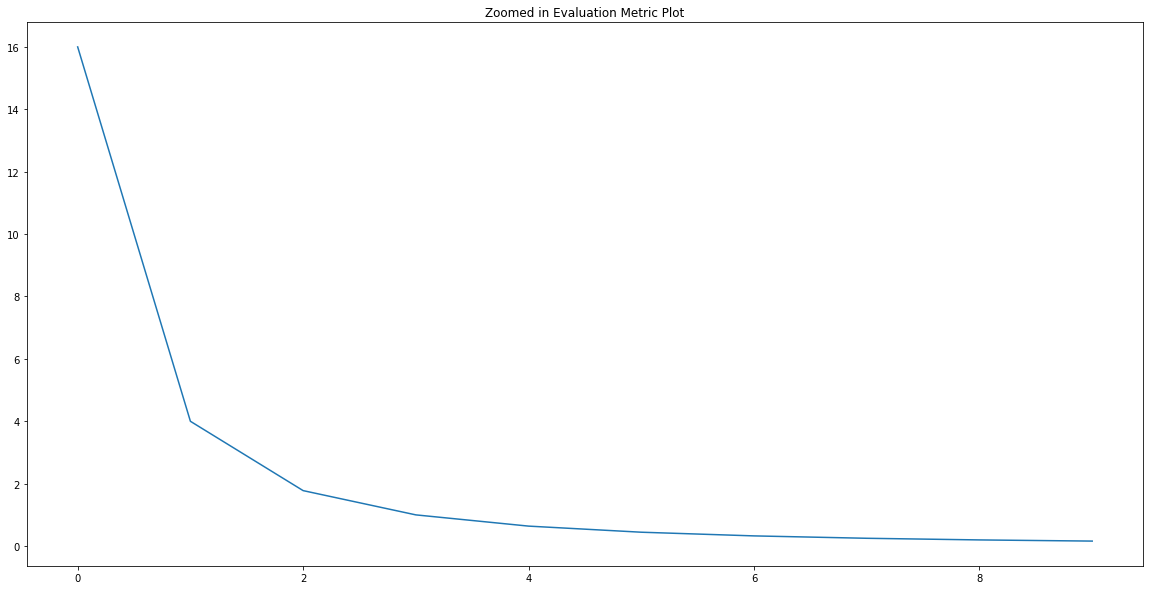

In [96]:
_, ax = plt.subplots(1,1, figsize=(20, 10))
ax.plot(final_metrics[:10])
ax.set_title('Zoomed in Evaluation Metric Plot')
plt.show()

In [120]:
number_of_clusters = 4
print('Clustering data into {} clusters'.format(number_of_clusters))
kms = KMeans(n_clusters=number_of_clusters, random_state=42)
kms.fit(actor_embeddings)
pred = kms.predict(actor_embeddings)
# https://stackoverflow.com/questions/60935289/ego-graph-in-networkx
cost1_metric = 0
cost2_metric = 0
for ele in np.random.choice(actor_nodes, number_of_cluster):
        temp_sub_graph = A.subgraph(ele)
        cost1_metric += cost1(temp_sub_graph, number_of_clusters)
        cost2_metric += cost2(temp_sub_graph, number_of_clusters)
final_cost = cost1_metric * cost2_metric
print('Cost1 Metric Value',cost1_metric)
print('Cost2 Metric Value',cost2_metric)
print('Final Metric Value',final_cost)

Clustering data into 4 clusters
Cost1 Metric Value 1.0
Cost2 Metric Value 1.0
Final Metric Value 1.0


<font color='blue'>Displaying similar actor clusters</font>

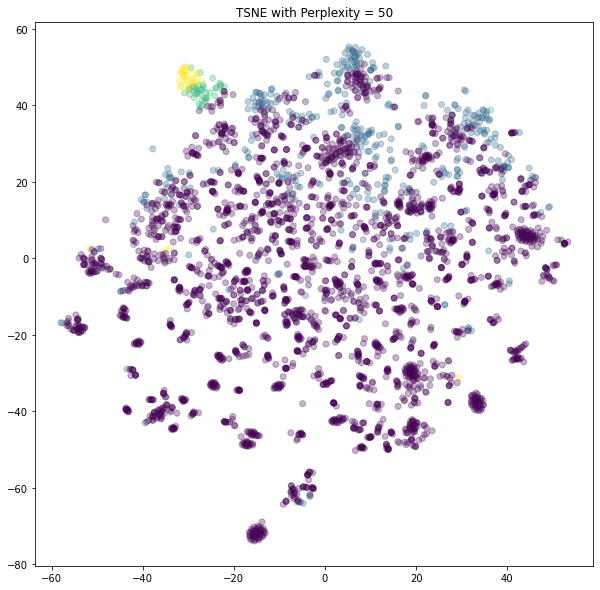

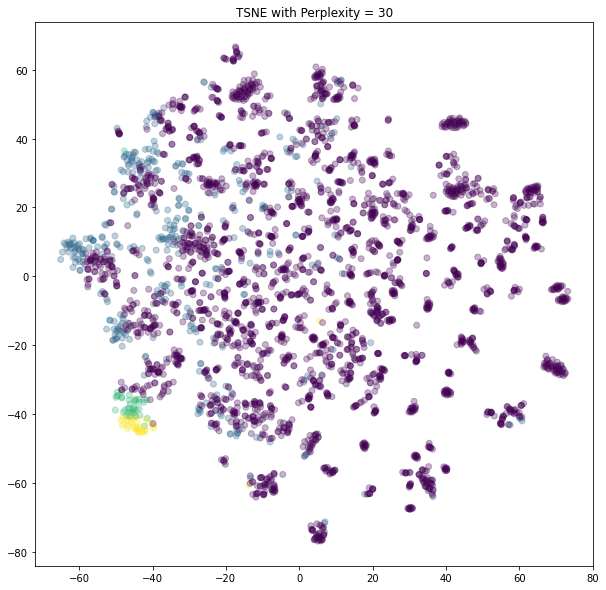

In [121]:
tsne = TSNE(n_components=2, perplexity=50)
actor_2d_transformation = tsne.fit_transform(actor_embeddings)

_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(actor_2d_transformation[:, 0], actor_2d_transformation[:, 1],
          c = pred, alpha=0.3)
ax.set_title('TSNE with Perplexity = 50')
plt.show()

tsne = TSNE(n_components=2, perplexity=30)
actor_2d_transformation = tsne.fit_transform(actor_embeddings)

_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(actor_2d_transformation[:, 0], actor_2d_transformation[:, 1],
          c = pred, alpha=0.3)
ax.set_title('TSNE with Perplexity = 30')
plt.show()

<font color='blue'>Grouping similar movies</font>

In [122]:
clusters = list(range(2,101))
final_metrics = []
for k in clusters:
    number_of_clusters = k
    print('Clustering data into {} clusters'.format(k))
    kms = KMeans(n_clusters=number_of_clusters, random_state=42)
    kms.fit(actor_embeddings)
    pred = kms.predict(movie_embeddings)
    cost1_metric = 0
    cost2_metric = 0
    for ele in np.random.choice(actor_nodes, number_of_cluster):
            temp_sub_graph = A.subgraph(ele)
            cost1_metric += cost1(temp_sub_graph, number_of_clusters)
            cost2_metric += cost2(temp_sub_graph, number_of_clusters)
    final_cost = cost1_metric * cost2_metric
    final_metrics.append(final_cost)
    print('Cost1 Metric Value',cost1_metric)
    print('Cost2 Metric Value',cost2_metric)
    print('Final Metric Value',final_cost)

Clustering data into 2 clusters
Cost1 Metric Value 2.0
Cost2 Metric Value 2.0
Final Metric Value 4.0
Clustering data into 3 clusters
Cost1 Metric Value 1.3333333333333333
Cost2 Metric Value 1.3333333333333333
Final Metric Value 1.7777777777777777
Clustering data into 4 clusters
Cost1 Metric Value 1.0
Cost2 Metric Value 1.0
Final Metric Value 1.0
Clustering data into 5 clusters
Cost1 Metric Value 0.8
Cost2 Metric Value 0.8
Final Metric Value 0.6400000000000001
Clustering data into 6 clusters
Cost1 Metric Value 0.6666666666666666
Cost2 Metric Value 0.6666666666666666
Final Metric Value 0.4444444444444444
Clustering data into 7 clusters
Cost1 Metric Value 0.5714285714285714
Cost2 Metric Value 0.5714285714285714
Final Metric Value 0.32653061224489793
Clustering data into 8 clusters
Cost1 Metric Value 0.5
Cost2 Metric Value 0.5
Final Metric Value 0.25
Clustering data into 9 clusters
Cost1 Metric Value 0.4444444444444444
Cost2 Metric Value 0.4444444444444444
Final Metric Value 0.197530864197

Cost1 Metric Value 0.06666666666666667
Cost2 Metric Value 0.06666666666666667
Final Metric Value 0.0044444444444444444
Clustering data into 61 clusters
Cost1 Metric Value 0.06557377049180328
Cost2 Metric Value 0.06557377049180328
Final Metric Value 0.004299919376511691
Clustering data into 62 clusters
Cost1 Metric Value 0.06451612903225806
Cost2 Metric Value 0.06451612903225806
Final Metric Value 0.004162330905306971
Clustering data into 63 clusters
Cost1 Metric Value 0.06349206349206349
Cost2 Metric Value 0.06349206349206349
Final Metric Value 0.004031242126480221
Clustering data into 64 clusters
Cost1 Metric Value 0.0625
Cost2 Metric Value 0.0625
Final Metric Value 0.00390625
Clustering data into 65 clusters
Cost1 Metric Value 0.06153846153846154
Cost2 Metric Value 0.06153846153846154
Final Metric Value 0.0037869822485207105
Clustering data into 66 clusters
Cost1 Metric Value 0.06060606060606061
Cost2 Metric Value 0.06060606060606061
Final Metric Value 0.0036730945821854917
Clusterin

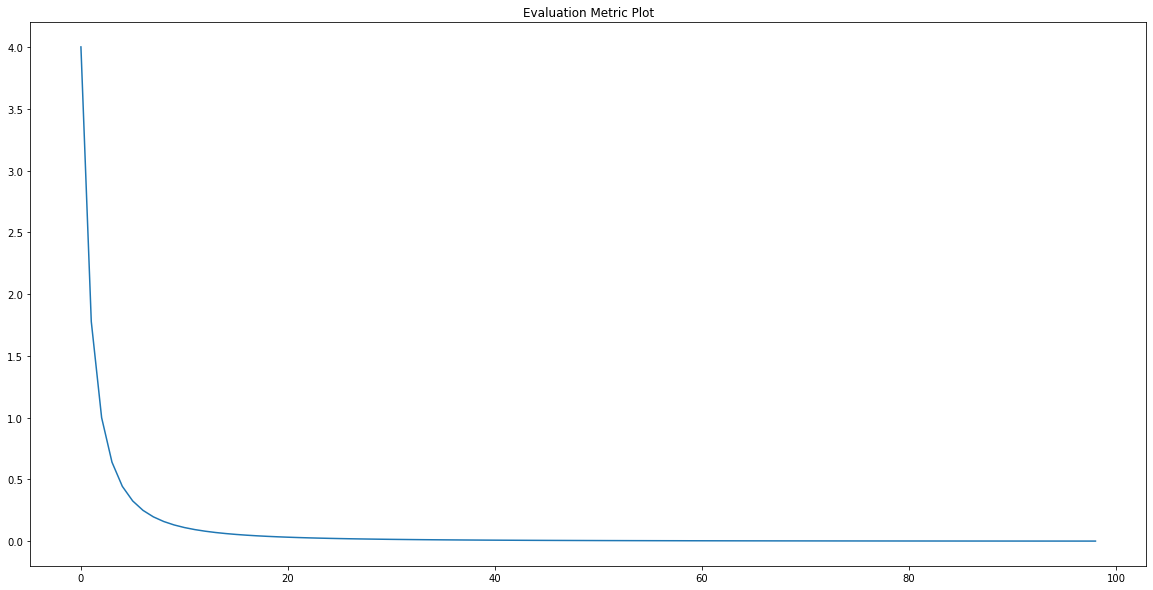

In [123]:
_, ax = plt.subplots(1,1, figsize=(20, 10))
ax.plot(final_metrics)
ax.set_title('Evaluation Metric Plot')
plt.show()

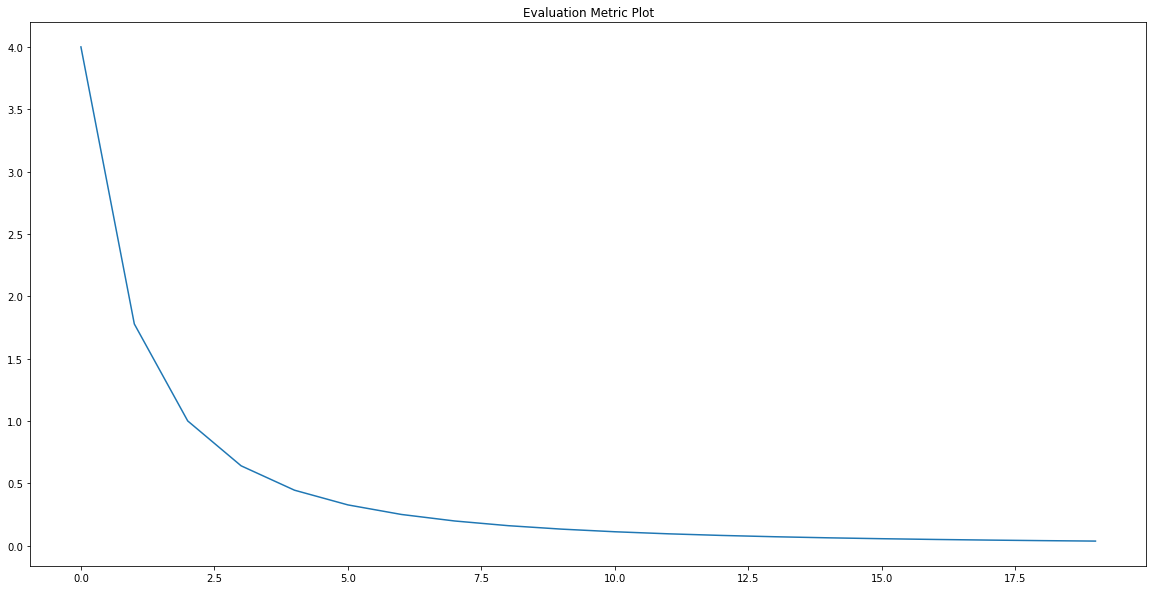

In [124]:
_, ax = plt.subplots(1,1, figsize=(20, 10))
ax.plot(final_metrics[:20])
ax.set_title('Evaluation Metric Plot')
plt.show()

<font color='blue'>Displaying similar movie clusters</font>

In [130]:
number_of_clusters = 4
print('Clustering data into {} clusters'.format(number_of_clusters))
kms = KMeans(n_clusters=number_of_clusters, random_state=42)
kms.fit(movie_embeddings)
pred = kms.predict(movie_embeddings)
# https://stackoverflow.com/questions/60935289/ego-graph-in-networkx
cost1_metric = 0
cost2_metric = 0
for ele in np.random.choice(movie_nodes, number_of_cluster):
        temp_sub_graph = A.subgraph(ele)
        cost1_metric += cost1(temp_sub_graph, number_of_clusters)
        cost2_metric += cost2(temp_sub_graph, number_of_clusters)
final_cost = cost1_metric * cost2_metric
print('Cost1 Metric Value',cost1_metric)
print('Cost2 Metric Value',cost2_metric)
print('Final Metric Value',final_cost)

Clustering data into 4 clusters
Cost1 Metric Value 1.0
Cost2 Metric Value 1.0
Final Metric Value 1.0


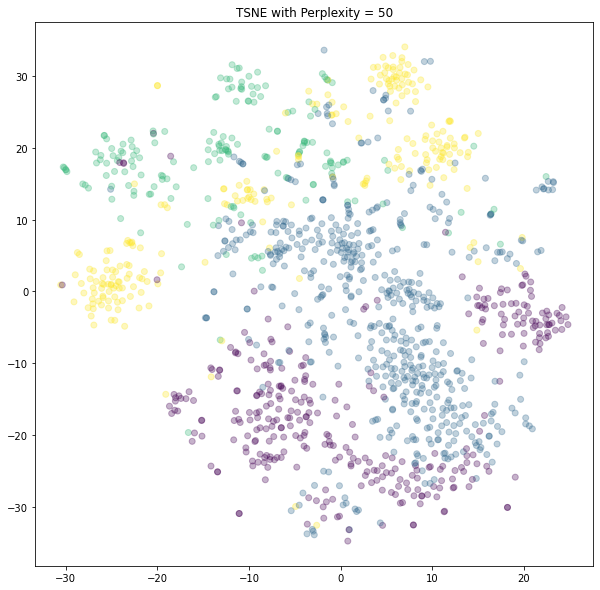

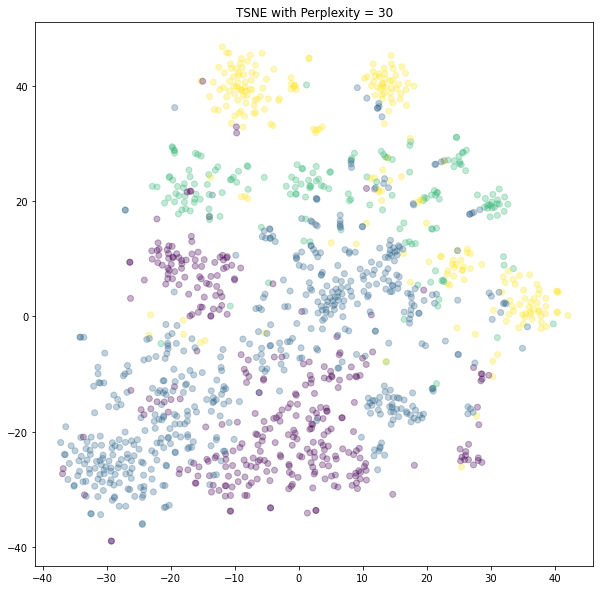

In [131]:
tsne = TSNE(n_components=2, perplexity=50)
movie_2d_transformation = tsne.fit_transform(movie_embeddings)

_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(movie_2d_transformation[:, 0], movie_2d_transformation[:, 1],
          c = pred, alpha=0.3)
ax.set_title('TSNE with Perplexity = 50')
plt.show()

tsne = TSNE(n_components=2, perplexity=30)
movie_2d_transformation = tsne.fit_transform(movie_embeddings)

_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(movie_2d_transformation[:, 0], movie_2d_transformation[:, 1],
          c = pred, alpha=0.3)
ax.set_title('TSNE with Perplexity = 30')
plt.show()